<a href="https://colab.research.google.com/github/khj021101/AI_Transformers/blob/main/Transformers01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!pip install torchtext==0.15.2

In [ ]:
!pip install portalocker==2.7.0

In [ ]:
!pip install accelerate -U

In [ ]:
from torchtext.datasets import IMDB

In [ ]:
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')

In [ ]:
import random
random.seed(6)
train_lists = list(train_iter)
test_lists = list(test_iter)

train_lists_small = random.sample(train_lists, 1000)
test_lists_small = random.sample(test_lists, 1000)

print(train_lists_small[0])
print(test_lists_small[0])

(2, "I LOVED this movie! I am biased seeing as I am a huge Disney fan, but I really enjoyed myself. The action takes off running in the beginning of the film and just keeps going! This is a bit of a departure for Disney, they don't spend quite as much time on character development (my husband pointed this out)and there are no musical numbers. It is strictly action adventure. I thoroughly enjoyed it and recommend it to anyone who loves Disney, be they young or old.")
(1, 'This was an abysmal show. In short it was about this kid called Doug who guilt-tripped a lot. Seriously he could feel guilty over killing a fly then feeling guilty over feeling guilty for killing the fly and so forth. The animation was grating and unpleasant and the jokes cheap. <br /><br />It aired here in Sweden as a part of the "Disney time" show and i remember liking it some what but then i turned 13.<br /><br />I never got why some of the characters were green and purple too. What was up with that? <br /><br />Tru

In [ ]:
train_texts = []
train_labels = []
for (label, text) in train_lists_small:
  train_labels.append(1 if label==2 else 0)
  train_texts.append(text)

test_texts = []
test_labels = []
for (label, text) in test_lists_small:
  test_labels.append(1 if label==2 else 0)
  test_texts.append(text)



In [ ]:
from sklearn.model_selection import train_test_split
(train_texts, val_texts, train_labels, val_labels) = train_test_split(train_texts, train_labels, test_size = 0.2, random_state=3)

print(len(train_texts))
print(len(train_labels))
print(len(val_texts))
print(len(val_texts))

800
800
200
200


In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

print(train_encodings["input_ids"][0][:5])

print(tokenizer.decode(train_encodings["input_ids"][0][:5]))

[101, 4937, 11350, 2038, 2048]
[CLS] cat soup has two


In [ ]:
import torch
class IMDbDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item
  def __len__(self):
    return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)



In [ ]:
for i in train_dataset:
  for j in i:
    print(j)
  break

input_ids
attention_mask
labels


In [ ]:
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
!nvidia-smi

Sat Jul 27 04:38:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0              29W /  70W |    413MiB / 15360MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
text1 = "I feel fantastic."
text2 = "My life is going something wrong"
text3 = "I have no figured out what the chosen title has to do with the movie"

input_tokens = tokenizer([text1, text2, text3], truncation = True, padding = True)

outputs = model(torch.tensor(input_tokens['input_ids']).to(device))

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [ ]:
label_dict = {0: 'negative', 1: 'positive'}

print([label_dict[i] for i in torch.argmax(outputs['logits'], axis = 1).cpu().numpy()])

['negative', 'positive', 'negative']


In [ ]:
from transformers import Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
)
trainer.train()

Step,Training Loss
10,0.689700
20,0.691800
30,0.695300
40,0.689400
50,0.686400
60,0.673100
70,0.668100
80,0.649700
90,0.600800
100,0.525300


TrainOutput(global_step=400, training_loss=0.2845322682056576, metrics={'train_runtime': 307.5182, 'train_samples_per_second': 20.812, 'train_steps_per_second': 1.301, 'total_flos': 847791351398400.0, 'train_loss': 0.2845322682056576, 'epoch': 8.0})

In [ ]:
text1 = "I feel fantastic."
text2 = "My life is going something wrong"
text3 = "I have no figured out what the chosen title has to do with the movie"

input_tokens = tokenizer([text1, text2, text3], truncation = True, padding = True)

outputs = model(torch.tensor(input_tokens['input_ids']).to(device))
label_dict = {0: 'negative', 1: 'positive'}

print([label_dict[i] for i in torch.argmax(outputs['logits'], axis = 1).cpu().numpy()])

#결과가 반대로 나오는 걸 보아하니 레이블이 반대인 듯하다

['positive', 'negative', 'negative']


In [ ]:
def test_inference(model, tokenizer):
  input_tokens = tokenizer([text1, text2, text3], truncation = True, padding = True)
  outputs = model(torch.tensor(input_tokens['input_ids']).to(device))
  label_dict = {0: 'negative', 1: 'positive'}
  return [label_dict[i] for i in torch.argmax(outputs['logits'], axis = 1).cpu().numpy()]
#

In [ ]:
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)

print(test_inference(model, tokenizer))
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
optim = AdamW(model.parameters(), lr=5e-5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['positive', 'positive', 'positive']


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model.train()
losses = []

for epoch in range(8):
  print(f'epoch: {epoch}')
  for batch in train_loader:
    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids, attention_mask = attention_mask, labels = labels)

    loss = outputs[0]
    losses.append(loss.item())

    loss.backward()

    optim.step()


model.eval()

print(test_inference(model, tokenizer))

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
['positive', 'negative', 'negative']


In [ ]:
print(losses)

[0.001254918286576867, 0.0010201323311775923, 0.0010725975735113025, 0.06147553399205208, 0.00233545177616179, 0.0011736317537724972, 0.0009578462922945619, 0.0010585844283923507, 0.0009998470777645707, 0.0012913153041154146, 0.001037799404002726, 0.002001396147534251, 0.0009568880195729434, 0.0009338622912764549, 0.000930745794903487, 0.0008232612744905055, 0.005577404517680407, 0.002167206024751067, 0.0009739939705468714, 0.0008288885001093149, 0.0010273486841470003, 0.0012345450231805444, 0.0009227438713423908, 0.002058357000350952, 0.0008526543388143182, 0.02898615039885044, 0.0011710338294506073, 0.0017521086847409606, 0.0011061684926971793, 0.0009830616181716323, 0.0008686439832672477, 0.0009349838946945965, 0.0009025391191244125, 0.0007377752917818725, 0.0007025483646430075, 0.0006572502315975726, 0.0008563625160604715, 0.0008434764458797872, 0.0006565998774021864, 0.000663770770188421, 0.0006729860906489193, 0.0008658728329464793, 0.0011048568412661552, 0.0007548831636086106, 0

In [ ]:
import matplotlib.pyplot as plt

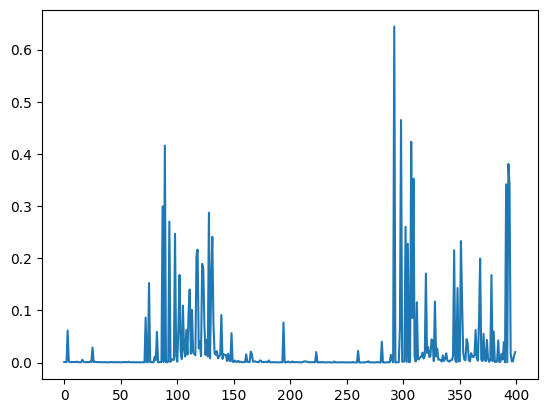

In [ ]:
plt.figure()
plt.plot(losses)
plt.show();


In [ ]:
model.eval()
l = []
for test_text in test_texts:
  input_tokens = tokenizer([test_text], truncation = True, padding = True)
  outputs = model(torch.tensor(input_tokens['input_ids']).to(device))
  l.append(torch.argmax(outputs['logits'], axis = 1).item())

correct_cnt = 0

for pred, ans in zip(l, test_labels):
  if pred == ans:
    correct_cnt += 1

print(correct_cnt/len(test_labels))


0.847


In [ ]:
tp = 0
tn = 0
fp = 0
fn = 0

for pred, ans in zip(l, test_labels):
  if pred == ans:
    if pred == 1:
      tp += 1
    else:
      tn += 1
  elif pred == 0:#negative로 예측했는데 FALSE이므로 FN이다.
    fn += 1
  elif pred == 1:
    fp += 1

In [ ]:
recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1_score = 2*recall*precision/(recall+precision)
print(recall, precision, f1_score)

0.7223382045929019 0.9453551912568307 0.8189349112426035


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, l))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       521
           1       0.95      0.72      0.82       479

    accuracy                           0.85      1000
   macro avg       0.87      0.84      0.84      1000
weighted avg       0.86      0.85      0.84      1000

